In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision      
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import sys

torch.manual_seed(1)    # reproducible
np.random.seed(seed = 1)

# Hyper Parameters
EPOCH = 50           
BATCH_SIZE = 500
LR = 0.001          

In [2]:
def random_select_data(array,ratio):
    selected_index = np.random.choice(array.shape[0],int(array.shape[0]/ratio),replace=False)
    array_selected = array[selected_index]
    return array_selected
def shuffle_along_axis(a, axis):
    np.random.seed(1)
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

In [3]:
# Prepare training data and testing data
with open("termite_g2_scaffold_image_dict_scaffold19_size10660809_17_fragment.pickle", "rb") as handle:
    unserialized_training_data = pickle.load(handle)

In [4]:
# OPTION!!! Prepare random negative data
with open("termite_g2_scaffold_RANDOM_image_array_100000_17_2_10_fragment.pickle", "rb") as handle:
    random_negative_data = pickle.load(handle)

In [6]:
# Make training and testing data
temp_stack_array = np.concatenate([unserialized_training_data[x] for x in unserialized_training_data], 0)

temp_stack_array_label = np.zeros(temp_stack_array.shape[0])
for index in np.arange(0,temp_stack_array.shape[0]):
    if len(temp_stack_array[index,1,:][temp_stack_array[index,1,:] != 0]):
        temp_stack_array_label[index] = 1 
pos_array_ori = temp_stack_array[temp_stack_array_label == 1]
neg_array_ori = temp_stack_array[temp_stack_array_label == 0]

######## Make random selected negative data
neg_array_ori_selected = random_select_data(neg_array_ori,16)

# OPTION!USE RANDOM DATA
#neg_array_ori_selected = random_select_data(random_negative_data,1)
pos_array_ori = random_select_data(pos_array_ori,1)


print("Positive data: ", pos_array_ori.shape)
print("Negative data: ", neg_array_ori_selected.shape)

Positive data:  (99146, 2, 17)
Negative data:  (98031, 2, 17)


In [7]:
POS_NEG_COMBINE_IMAGE = np.concatenate((pos_array_ori,neg_array_ori_selected),axis=0)
POS_LABEL = np.ones(pos_array_ori.shape[0])
NEG_LABEL = np.zeros(neg_array_ori_selected.shape[0])
POS_NEG_COMBINE_LABEL = np.concatenate((POS_LABEL,NEG_LABEL),axis=0)


POS_NEG_COMBINE_IMAGE_shuffle = shuffle_along_axis(POS_NEG_COMBINE_IMAGE, axis = 0)
POS_NEG_COMBINE_LABEL_shuffle = shuffle_along_axis(POS_NEG_COMBINE_LABEL, axis = 0)

# Separate training and testing data
X_train, X_test, y_train, y_test = train_test_split(POS_NEG_COMBINE_IMAGE_shuffle, POS_NEG_COMBINE_LABEL_shuffle, test_size=0.25, random_state=42)
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

print("Training image: ", X_train.shape)
print("Training label: ", y_train.shape)
print("Testing image: ", X_test.shape)
print("Testing label: ", y_test.shape)

Training image:  (147882, 1, 2, 17)
Training label:  (147882,)
Testing image:  (49295, 1, 2, 17)
Testing label:  (49295,)


In [8]:
# Numpy to Torch
X_train_torch = torch.from_numpy(X_train)
X_test_torch = torch.from_numpy(X_test)
y_train_torch = torch.from_numpy(y_train)
y_test_torch = torch.from_numpy(y_test)

X_train_torch = X_train_torch.float()
y_train_torch = y_train_torch.long() 

X_test_torch = X_test_torch.float()
y_test_torch = y_test_torch.long()

print("Training image: ", X_train_torch.shape)
print("Training label: ", y_train_torch.shape)
print("Testing image: ", X_test_torch.shape)
print("Testing label: ", y_test_torch.shape)

Training image:  torch.Size([147882, 1, 2, 17])
Training label:  torch.Size([147882])
Testing image:  torch.Size([49295, 1, 2, 17])
Testing label:  torch.Size([49295])


In [9]:
# Make batch
trainloader = torch.utils.data.DataLoader(X_train_torch, BATCH_SIZE, shuffle=False, num_workers=8) 
trainloader_label = torch.utils.data.DataLoader(y_train_torch, BATCH_SIZE, shuffle=False, num_workers=8)

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(  # input shape (1, 28, 28) (1,2,65)
            nn.Conv2d(
                in_channels=1,      # input height
                out_channels=64,    # n_filters
                kernel_size=1,      # filter size
                stride=1,           # filter movement/step
                padding=0,      #  padding=(kernel_size-1)/2 当 stride=1
            ),      # output shape (16, 28, 28)
            nn.ReLU(),    # activation
            #nn.MaxPool2d(kernel_size=2),    # output shape (16, 14, 14) (16,1,33)
        )
        self.conv2 = nn.Sequential(  # input shape (16, 14, 14) (16,1,33)
            nn.Conv2d(64, 256, 1, 1, padding=0),  # output shape (32, 14, 14) (32,1,33)
            nn.ReLU(),  # activation
            #nn.MaxPool2d(2),  # output shape (32, 7, 7)
        )
        self.conv3 = nn.Sequential(  # input shape (16, 14, 14) (16,1,33)
            nn.Conv2d(256, 1024, 1, 1, padding=0),  # output shape (32, 14, 14) (32,1,33)
            nn.ReLU(),  # activation
            #nn.MaxPool2d(2),  # output shape (32, 7, 7)
        )
        self.conv4 = nn.Sequential(  # input shape (16, 14, 14) (16,1,33)
        nn.Conv2d(1024, 256, 1, 1, padding=0),  # output shape (32, 14, 14) (32,1,33)
        nn.ReLU(),  # activation
        #nn.MaxPool2d(2),  # output shape (32, 7, 7)
        )
        self.conv5 = nn.Sequential(  # input shape (16, 14, 14) (16,1,33)
        nn.Conv2d(256, 64, 1, 1, padding=0),  # output shape (32, 14, 14) (32,1,33)
        nn.ReLU(),  # activation
        #nn.MaxPool2d(2),  # output shape (32, 7, 7)
        )
        
        self.out = nn.Linear(2176, 2)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)   # (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output

cnn = CNN()
print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
  )
  (out): Linear(in_features=2176, out_features=2, bias=True)
)


epoch:  0
Loss in epoch 0  =  0.6931424585951341
Accuracy in epoch 0  =  0.5024140869071286
True positive:  69624  /  147882
True negative:  4674  /  147882
False positive:  68758  /  147882
False negative:  4826  /  147882
epoch:  1
Loss in epoch 1  =  0.6931401928131645
Accuracy in epoch 1  =  0.502873912984677
True positive:  70408  /  147882
True negative:  3958  /  147882
False positive:  69474  /  147882
False negative:  4042  /  147882
epoch:  2
Loss in epoch 2  =  0.6931401992569098
Accuracy in epoch 2  =  0.5028333400954815
True positive:  70655  /  147882
True negative:  3705  /  147882
False positive:  69727  /  147882
False negative:  3795  /  147882
epoch:  3
Loss in epoch 3  =  0.6931401603930706
Accuracy in epoch 3  =  0.5028333400954815
True positive:  70655  /  147882
True negative:  3705  /  147882
False positive:  69727  /  147882
False negative:  3795  /  147882
epoch:  4
Loss in epoch 4  =  0.6931401656286137
Accuracy in epoch 4  =  0.5028333400954815
True positive

Loss in epoch 30  =  0.6931400472247923
Accuracy in epoch 30  =  0.5028333400954815
True positive:  70655  /  147882
True negative:  3705  /  147882
False positive:  69727  /  147882
False negative:  3795  /  147882
epoch:  31
Loss in epoch 31  =  0.6931400514535002
Accuracy in epoch 31  =  0.5028333400954815
True positive:  70655  /  147882
True negative:  3705  /  147882
False positive:  69727  /  147882
False negative:  3795  /  147882
epoch:  32
Loss in epoch 32  =  0.6931400518562343
Accuracy in epoch 32  =  0.5028333400954815
True positive:  70655  /  147882
True negative:  3705  /  147882
False positive:  69727  /  147882
False negative:  3795  /  147882
epoch:  33
Loss in epoch 33  =  0.6931400518562343
Accuracy in epoch 33  =  0.5028333400954815
True positive:  70655  /  147882
True negative:  3705  /  147882
False positive:  69727  /  147882
False negative:  3795  /  147882
epoch:  34
Loss in epoch 34  =  0.6931400514535002
Accuracy in epoch 34  =  0.5028333400954815
True pos

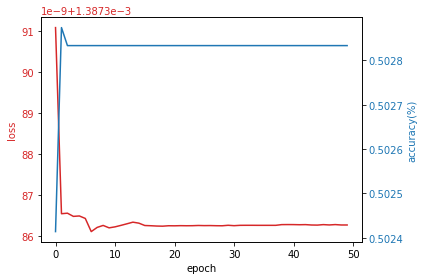

In [14]:
import torch.nn.functional as F
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters

loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted
#loss_func = torch.nn.BCELoss(reduce=False, size_average=False)
#loss_func = torch.nn.NLLLoss(reduce=True, size_average=True)

correct = 0
total = 0
loss_list = []
accuracy_list = []
TP_list = []
TN_list = []
FP_list = []
FN_list = []


# training and testing
step_length = len(trainloader)

for epoch in range(EPOCH):
    print("epoch: ", epoch)
    LOSS = 0
    ACC = 0
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    sum_epoch = 0
    for step, (b_x, b_y) in enumerate(zip(trainloader, trainloader_label)):   
        processing = str(round(((step)/ step_length * 100),2)) + "%" +"\r"
        sys.stdout.write(processing)
        sys.stdout.flush()
        
        
        
        output = cnn(b_x)               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        #loss = loss_func(F.sigmoid(output), b_y)
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        
        pred_temp = torch.max(output, 1)[1].data.numpy().squeeze()
        LOSS += loss.item()
        b_y_numpy = b_y.numpy()
        sum_epoch += len(b_y)
        
        ACC += len(b_y_numpy[b_y_numpy == pred_temp])
        TP += sum((b_y_numpy == 1) & (pred_temp == 1))
        TN += sum((b_y_numpy == 0) & (pred_temp == 0))
        FP += sum((b_y_numpy == 0) & (pred_temp == 1))
        FN += sum((b_y_numpy == 1) & (pred_temp == 0))
        
        
    print("Loss in epoch", epoch," = ", LOSS/step_length)
    print("Accuracy in epoch", epoch," = ", ACC/sum_epoch)
    print("True positive: ", TP," / ",sum_epoch)
    print("True negative: ", TN," / ",sum_epoch)
    print("False positive: ", FP," / ",sum_epoch)
    print("False negative: ", FN," / ",sum_epoch)
    loss_list.append(LOSS/sum_epoch)
    accuracy_list.append(ACC/sum_epoch)
    TP_list.append(TP)
    TN_list.append(TN)
    FP_list.append(FP)
    FN_list.append(FN)
    
    print("=====================================================")
fig, ax1 = plt.subplots()
t = np.arange(0,EPOCH)

color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss', color=color)
ax1.plot(t, loss_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy(%)', color=color)  # we already handled the x-label with ax1
ax2.plot(t, accuracy_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

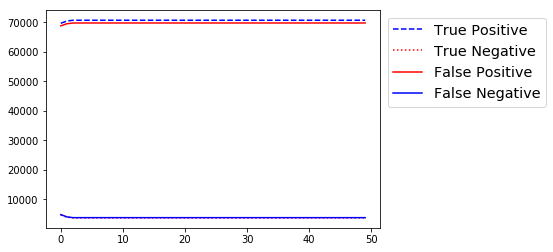

In [15]:
fig, ax = plt.subplots()
ax.plot(t, TP_list, 'b--', label= "True Positive")
ax.plot(t, TN_list, 'r:', label= "True Negative")
ax.plot(t, FP_list, 'r', label= "False Positive")
ax.plot(t, FN_list, "b", label= "False Negative")

legend = ax.legend(bbox_to_anchor=(1, 1), fontsize='x-large')

# Put a nicer background color on the legend.

plt.show()

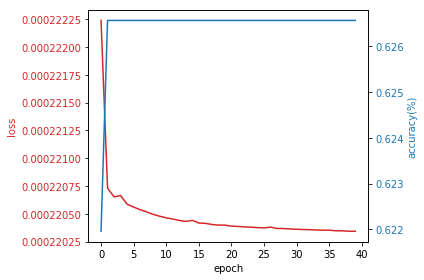

In [17]:
fig, ax1 = plt.subplots()
t = np.arange(0,40)

color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss', color=color)
ax1.plot(t, loss_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy(%)', color=color)  # we already handled the x-label with ax1
ax2.plot(t, accuracy_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()